In [183]:
import os
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import root_mean_squared_error as rmse

## Loading data

In [184]:
DATA_PATH = '/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Forecasting-water-inflow/Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated.csv'

# Adjust these column names as needed.
date_col = 'time'
target_col = 'KarupBro'
# List of meteorological features from DMI – update if needed.
input_cols = [
    'temp_min_daily', 'temp_max_daily', 'temp_mean_daily', 
    'temp_grass_mean_daily', 'temp_soil_min_daily', 'temp_soil_max_daily', 
    'temp_soil_mean_daily', 'humidity_daily', 'wind_direction_daily', 
    'wind_speed_daily', 'wind_gust_max_daily', 'precip_total_daily', 
    'precip_duration_daily', 'radiation_global_daily', 
    'sunshine_duration_daily'
]


# Read the CSV
df = pd.read_csv(DATA_PATH, parse_dates=[date_col])
df.sort_values(date_col, inplace=True)
df.reset_index(drop=True, inplace=True)

# Optional: Set the date column as index (if needed)
df.set_index(date_col, inplace=True)

df.tail()

,temp_min_daily,temp_max_daily,temp_mean_daily,temp_grass_mean_daily,temp_soil_min_daily,temp_soil_max_daily,temp_soil_mean_daily,humidity_daily,wind_direction_daily,wind_gust_max_daily,wind_speed_daily,precip_total_daily,precip_duration_daily,radiation_global_daily,sunshine_duration_daily,KarupBro
time,,,,,,,,,,,,,,,,
2023-12-20,0.8,4.4,3.141667,2.316667,5.1,5.4,5.241667,88.583333,252.000000,12.2,2.541667,0.4,4.0,349.0,111.0,4448.18
2023-12-21,1.4,8.7,5.316667,4.637500,5.0,5.3,5.141667,86.083333,254.666667,22.5,5.329167,19.9,159.0,270.0,29.5,5602.14
2023-12-22,0.1,4.0,2.395833,1.129167,4.0,5.1,4.533333,66.000000,293.416667,19.1,5.020833,0.6,3.0,749.0,294.5,6636.60
2023-12-23,-1.6,3.3,0.833333,-0.250000,3.6,4.1,3.754167,88.000000,264.000000,10.5,2.379167,0.8,4.0,589.0,247.0,5809.15
2023-12-24,-0.3,2.1,1.120000,0.700000,3.4,3.6,3.520000,97.700000,136.500000,6.6,1.500000,5.0,38.0,9.0,0.0,5197.78


In [185]:
# Check for missing values
df.isnull().sum()

temp_min_daily             0
temp_max_daily             0
temp_mean_daily            0
temp_grass_mean_daily      0
temp_soil_min_daily        0
temp_soil_max_daily        0
temp_soil_mean_daily       0
humidity_daily             0
wind_direction_daily       0
wind_gust_max_daily        0
wind_speed_daily           0
precip_total_daily         0
precip_duration_daily      0
radiation_global_daily     0
sunshine_duration_daily    0
KarupBro                   0
dtype: int64

<Figure size 1200x1200 with 0 Axes>

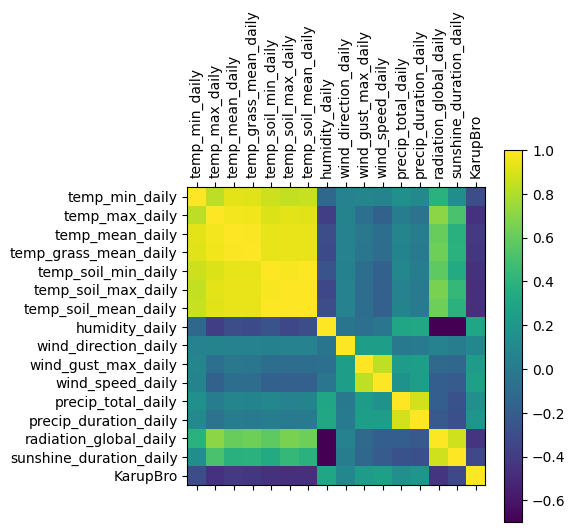

In [219]:
# Correlation matrix
corr = df.corr()
plt.figure(figsize=(12, 12))
plt.matshow(corr, fignum=2)
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.show()

## Filtering data to simple model

In [186]:
df_simple = df[["temp_mean_daily", "precip_total_daily", "KarupBro"]]
df_simple.head()

,temp_mean_daily,precip_total_daily,KarupBro
time,,,
2002-01-01,1.250000,2.2,1829.75
2002-01-02,-0.837500,0.0,7279.46
2002-01-03,-5.166667,0.0,5261.85
2002-01-04,-6.025000,0.0,2951.97
2002-01-05,-3.466667,0.1,1868.53


<Axes: xlabel='time'>

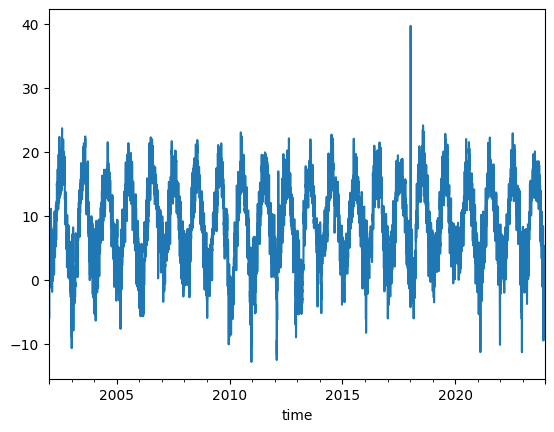

In [187]:
temp = df['temp_mean_daily']
temp.plot()

In [188]:
# Replace outliers with NaN
df.loc[df["temp_mean_daily"] > 35, "temp_mean_daily"] = np.nan

# Forward-fill (ffill) the missing values
df["temp_mean_daily"] = df["temp_mean_daily"].ffill()

<Axes: xlabel='time'>

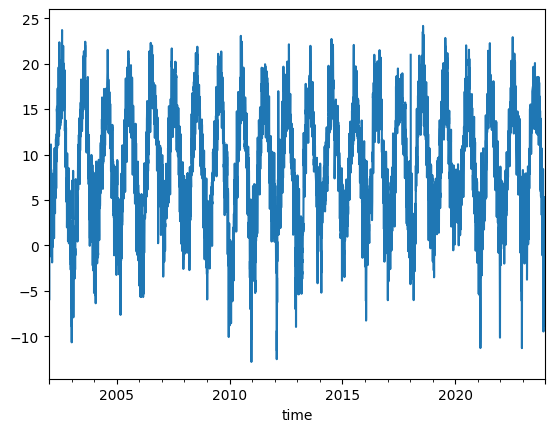

In [189]:
temp.plot()

<Axes: xlabel='time'>

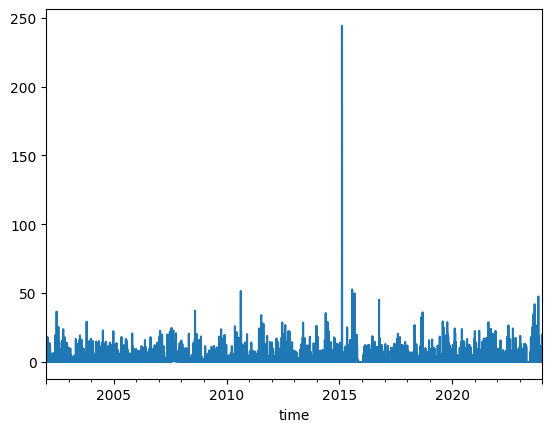

In [190]:
rain = df['precip_total_daily']
rain.plot()

In [191]:
import numpy as np

# Replace outliers with NaN
df.loc[df["precip_total_daily"] > 100, "precip_total_daily"] = np.nan

# Forward-fill (ffill) the missing values
df["precip_total_daily"] = df["precip_total_daily"].ffill()

<Axes: xlabel='time'>

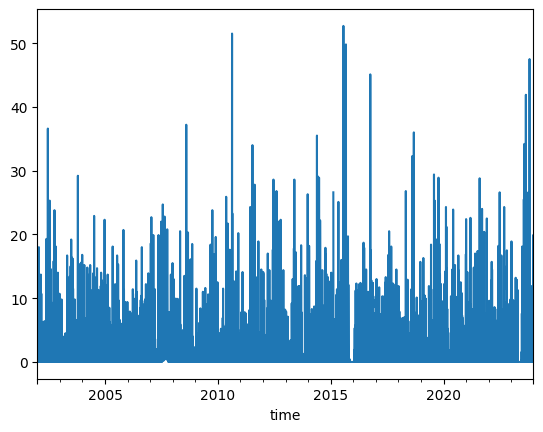

In [192]:
rain.plot()

<Axes: xlabel='time'>

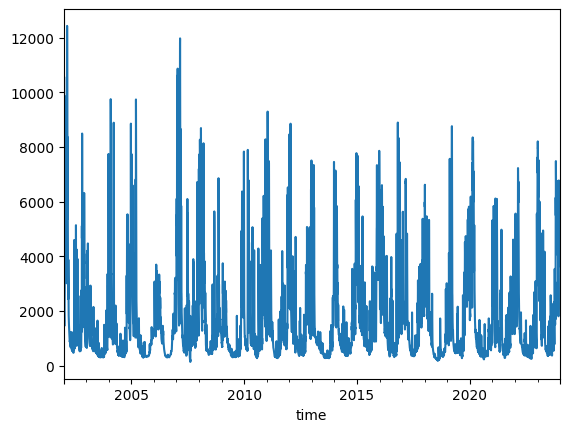

In [193]:
inflow = df['KarupBro']
inflow.plot()

## Multi-variable

In [194]:
inflow_df = pd.DataFrame({'Inflow':inflow})
inflow_df['Seconds'] = inflow_df.index.map(pd.Timestamp.timestamp)
inflow_df

,Inflow,Seconds
time,,
2002-01-01,1829.75,1.009843e+09
2002-01-02,7279.46,1.009930e+09
2002-01-03,5261.85,1.010016e+09
2002-01-04,2951.97,1.010102e+09
2002-01-05,1868.53,1.010189e+09
...,...,...
2023-12-20,4448.18,1.703030e+09
2023-12-21,5602.14,1.703117e+09
2023-12-22,6636.60,1.703203e+09


In [195]:
day = 24*60*60
year = (365.2425)*day

inflow_df['Rain'] = df['precip_total_daily']
inflow_df['Temp'] = df['temp_mean_daily']
inflow_df['Year sin'] = np.sin(inflow_df['Seconds'] * (2 * np.pi / year))
inflow_df['Year cos'] = np.cos(inflow_df['Seconds'] * (2 * np.pi / year))
inflow_df = inflow_df.drop('Seconds', axis=1)
inflow_df

,Inflow,Rain,Temp,Year sin,Year cos
time,,,,,
2002-01-01,1829.75,2.2,1.250000,0.004129,0.999991
2002-01-02,7279.46,0.0,-0.837500,0.021330,0.999772
2002-01-03,5261.85,0.0,-5.166667,0.038525,0.999258
2002-01-04,2951.97,0.0,-6.025000,0.055708,0.998447
2002-01-05,1868.53,0.1,-3.466667,0.072875,0.997341
...,...,...,...,...,...
2023-12-20,4448.18,0.4,3.141667,-0.206570,0.978432
2023-12-21,5602.14,19.9,5.316667,-0.189708,0.981841
2023-12-22,6636.60,0.6,2.395833,-0.172790,0.984959


In [ ]:
import numpy as np

HORIZON = 1
WINDOW = 5

def df_to_X_y_multi_step_exo(df, window_size=WINDOW, horizon=HORIZON):
    """
    Prepares data for direct multi-step forecasting (k-step ahead) by:
      - Using the past 'window_size' days of data as historical input.
      - Including the exogenous features (Rain, Temp, cos_year, sin_year) 
        for the *next* 'horizon' days.
      - Predicting 'horizon' days of inflow in one shot.

    Assumes:
      - df columns = [Inflow, Rain, Temp, cos_year, sin_year]
      - 'window_size' = number of past days (e.g., 5)
      - 'horizon' = forecast length (e.g., 3)

    Returns:
      X : shape (num_samples, window_size, 5 + 4*horizon)
          The last row of each sample contains the exogenous data for each future day.
      y : shape (num_samples, horizon)
          The inflow values for the next 'horizon' days.
    """
    df_as_np = df.to_numpy()  # shape (total_days, 5)
    X, y = [], []
    n = len(df_as_np)
    
    # We need enough data for 'window_size' historical days + 'horizon' future days
    for i in range(n - window_size - horizon + 1):
        # 1) Extract the 5-day historical window: shape (window_size, 5)
        hist_window = df_as_np[i : i + window_size, :5]
        
        # 2) Extract the exogenous features for the next 'horizon' days (cols 1..4)
        #    shape (horizon, 4)
        exo_future = df_as_np[i + window_size : i + window_size + horizon, 1:5]
        
        # 3) Build an expanded window with shape (window_size, 5 + 4*horizon)
        #    We copy the original 5 features into columns 0..4 for every row,
        #    and in the *last row only*, we append the horizon exo data.
        sample = np.zeros((window_size, 5 + 4 * horizon))
        
        # Fill columns 0..4 with the historical data for each of the 'window_size' rows
        sample[:, :5] = hist_window
        
        # For the last row, place each day's exo in the extra columns
        # day 0 exo goes to columns [5..9), day 1 exo goes to [9..13), etc.
        for day_idx in range(horizon):
            start_col = 5 + 4 * day_idx
            end_col   = start_col + 4
            sample[-1, start_col:end_col] = exo_future[day_idx]
        
        # 4) The label is the inflow for the next 'horizon' days: shape (horizon,)
        future_inflow = df_as_np[i + window_size : i + window_size + horizon, 0]
        
        X.append(sample)
        y.append(future_inflow)
    
    return np.array(X), np.array(y)

In [197]:
# X2, y2 = df_to_X_y2(inflow_df)
X, y = df_to_X_y_multi_step_exo(inflow_df)

X.shape, y.shape

((8023, 5, 9), (8023, 1))

In [198]:
X2_train, y2_train = X[:6000], y[:6000]
X2_val, y2_val = X[6000:7000], y[6000:7000]
X2_test, y2_test = X[7000:], y[7000:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((6000, 5, 9), (6000, 1), (1000, 5, 9), (1000, 1), (1023, 5, 9), (1023, 1))

### Preprocessing

In [199]:
# Compute the training statistics from the first channel (inflow) in X2_train
inflow_training_mean = np.mean(X2_train[:, :, 0])
inflow_training_std = np.std(X2_train[:, :, 0])

rain_training_mean = np.mean(X2_train[:, :, 1])
rain_training_std = np.std(X2_train[:, :, 1])

temp_training_mean = np.mean(X2_train[:, :, 2])
temp_training_std = np.std(X2_train[:, :, 2])

# Define the preprocessing functions for features and output
def preprocess(X):
    # Standardize the first three channels (features)
    X[:, :, 0] = (X[:, :, 0] - inflow_training_mean) / inflow_training_std 
    X[:, :, 1] = (X[:, :, 1] - rain_training_mean) / rain_training_std
    X[:, :, 2] = (X[:, :, 2] - temp_training_mean) / temp_training_std 
    return X

def preprocess_output(y):
    # Standardize every element in y
    y[:] = (y[:] - inflow_training_mean) / inflow_training_std
    return y

# Apply preprocessing to all datasets
preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)
preprocess_output(y2_train)
preprocess_output(y2_val)
preprocess_output(y2_test)

array([[-0.38355823],
       [-0.44990893],
       [-0.47533252],
       ...,
       [ 3.00218845],
       [ 2.50380534],
       [ 2.13556981]])

In [200]:
X2_test[0] , y2_test[0]

(array([[-0.16178693, -0.47387479, -1.02918874,  0.86394287,  0.50358984,
          0.        ,  0.        ,  0.        ,  0.        ],
        [-0.20456313, -0.47387479, -1.23306787,  0.87247775,  0.48865384,
          0.        ,  0.        ,  0.        ,  0.        ],
        [-0.23627486, -0.47387479, -1.06207248,  0.88075444,  0.47357324,
          0.        ,  0.        ,  0.        ,  0.        ],
        [-0.34346834, -0.47387479, -1.5717703 ,  0.8887705 ,  0.45835249,
          0.        ,  0.        ,  0.        ,  0.        ],
        [-0.3823777 , -0.44891571, -1.00682781,  0.89652354,  0.4429961 ,
          0.        ,  2.2625    ,  0.90401127,  0.42750862]]),
 array([-0.38355823]))

In [201]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense

model4 = Sequential()
model4.add(InputLayer(input_shape=(WINDOW, 5+4*HORIZON)))  # (window_size, 5 + 4*horizon)
model4.add(LSTM(64, activation='relu'))
model4.add(Dense(32, activation='relu'))
# Output 3 values at once (for 3-day forecast)
model4.add(Dense(HORIZON, activation='linear'))

model4.compile(optimizer='adam', loss='mse')
model4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 64)                18944     
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 21057 (82.25 KB)
Trainable params: 21057 (82.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [202]:
cp4 = ModelCheckpoint('model4/', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [203]:
model4.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=100, callbacks=[cp4])

Epoch 1/100
164/188 [=========================>....] - ETA: 0s - loss: 0.8736 - root_mean_squared_error: 0.9347INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 5ms/step - loss: 0.8396 - root_mean_squared_error: 0.9163 - val_loss: 0.6127 - val_root_mean_squared_error: 0.7827
Epoch 2/100
174/188 [==========================>...] - ETA: 0s - loss: 0.4071 - root_mean_squared_error: 0.6380INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.3994 - root_mean_squared_error: 0.6319 - val_loss: 0.2000 - val_root_mean_squared_error: 0.4472
Epoch 3/100
169/188 [=========================>....] - ETA: 0s - loss: 0.2405 - root_mean_squared_error: 0.4904INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.2360 - root_mean_squared_error: 0.4857 - val_loss: 0.1244 - val_root_mean_squared_error: 0.3527
Epoch 4/100
180/188 [===========================>..] - ETA: 0s - loss: 0.1832 - root_mean_squared_error: 0.4281INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 6ms/step - loss: 0.1843 - root_mean_squared_error: 0.4293 - val_loss: 0.0904 - val_root_mean_squared_error: 0.3006
Epoch 5/100
175/188 [==========================>...] - ETA: 0s - loss: 0.1465 - root_mean_squared_error: 0.3827INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 5ms/step - loss: 0.1464 - root_mean_squared_error: 0.3826 - val_loss: 0.0679 - val_root_mean_squared_error: 0.2605
Epoch 6/100
172/188 [==========================>...] - ETA: 0s - loss: 0.1189 - root_mean_squared_error: 0.3448INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 6ms/step - loss: 0.1203 - root_mean_squared_error: 0.3468 - val_loss: 0.0568 - val_root_mean_squared_error: 0.2383
Epoch 7/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1055 - root_mean_squared_error: 0.3248 - val_loss: 0.0617 - val_root_mean_squared_error: 0.2485
Epoch 8/100
169/188 [=========================>....] - ETA: 0s - loss: 0.0952 - root_mean_squared_error: 0.3085INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.0949 - root_mean_squared_error: 0.3081 - val_loss: 0.0511 - val_root_mean_squared_error: 0.2259
Epoch 9/100
172/188 [==========================>...] - ETA: 0s - loss: 0.0912 - root_mean_squared_error: 0.3019INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.0879 - root_mean_squared_error: 0.2965 - val_loss: 0.0451 - val_root_mean_squared_error: 0.2124
Epoch 10/100
175/188 [==========================>...] - ETA: 0s - loss: 0.0815 - root_mean_squared_error: 0.2855INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.0814 - root_mean_squared_error: 0.2854 - val_loss: 0.0447 - val_root_mean_squared_error: 0.2115
Epoch 11/100
182/188 [============================>.] - ETA: 0s - loss: 0.0788 - root_mean_squared_error: 0.2807INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 0.0779 - root_mean_squared_error: 0.2791 - val_loss: 0.0392 - val_root_mean_squared_error: 0.1980
Epoch 12/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0752 - root_mean_squared_error: 0.2742 - val_loss: 0.0428 - val_root_mean_squared_error: 0.2068
Epoch 13/100
188/188 [==============================] - 0s 1ms/step - loss: 0.0728 - root_mean_squared_error: 0.2698 - val_loss: 0.0565 - val_root_mean_squared_error: 0.2377
Epoch 14/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0711 - root_mean_squared_error: 0.2666 - val_loss: 0.0464 - val_root_mean_squared_error: 0.2154
Epoch 15/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0693 - root_mean_squared_error: 0.2632 - val_loss: 0.0438 - val_root_mean_squared_error: 0.2092
Epoch 16/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0678 - root_mean_squared_error: 0.2604 - val_loss: 0.0439 - val_r

INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 5ms/step - loss: 0.0666 - root_mean_squared_error: 0.2581 - val_loss: 0.0374 - val_root_mean_squared_error: 0.1934
Epoch 18/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0650 - root_mean_squared_error: 0.2550 - val_loss: 0.0425 - val_root_mean_squared_error: 0.2061
Epoch 19/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0645 - root_mean_squared_error: 0.2539 - val_loss: 0.0421 - val_root_mean_squared_error: 0.2051
Epoch 20/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0631 - root_mean_squared_error: 0.2511 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1941
Epoch 21/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0622 - root_mean_squared_error: 0.2493 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1942
Epoch 22/100
181/188 [===========================>..] - ETA: 0s - loss: 0.0620 - root_mean_squared_error: 0.2489INFO:tensorflow:Assets written 

INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.0614 - root_mean_squared_error: 0.2478 - val_loss: 0.0345 - val_root_mean_squared_error: 0.1858
Epoch 23/100
184/188 [============================>.] - ETA: 0s - loss: 0.0617 - root_mean_squared_error: 0.2484INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.0610 - root_mean_squared_error: 0.2470 - val_loss: 0.0344 - val_root_mean_squared_error: 0.1855
Epoch 24/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0601 - root_mean_squared_error: 0.2452 - val_loss: 0.0363 - val_root_mean_squared_error: 0.1906
Epoch 25/100
188/188 [==============================] - ETA: 0s - loss: 0.0600 - root_mean_squared_error: 0.2449INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.0600 - root_mean_squared_error: 0.2449 - val_loss: 0.0324 - val_root_mean_squared_error: 0.1801
Epoch 26/100
188/188 [==============================] - 0s 1ms/step - loss: 0.0589 - root_mean_squared_error: 0.2426 - val_loss: 0.0402 - val_root_mean_squared_error: 0.2004
Epoch 27/100
188/188 [==============================] - 0s 1ms/step - loss: 0.0579 - root_mean_squared_error: 0.2406 - val_loss: 0.0412 - val_root_mean_squared_error: 0.2031
Epoch 28/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0583 - root_mean_squared_error: 0.2414 - val_loss: 0.0347 - val_root_mean_squared_error: 0.1864
Epoch 29/100
188/188 [==============================] - 0s 1ms/step - loss: 0.0572 - root_mean_squared_error: 0.2392 - val_loss: 0.0334 - val_root_mean_squared_error: 0.1828
Epoch 30/100
188/188 [==============================] - 0s 1ms/step - loss: 0.0573 - root_mean_squared_error: 0.2394 - val_loss: 0.0334 - val_r

INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 5ms/step - loss: 0.0555 - root_mean_squared_error: 0.2356 - val_loss: 0.0320 - val_root_mean_squared_error: 0.1788
Epoch 34/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0549 - root_mean_squared_error: 0.2343 - val_loss: 0.0334 - val_root_mean_squared_error: 0.1826
Epoch 35/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0547 - root_mean_squared_error: 0.2338 - val_loss: 0.0346 - val_root_mean_squared_error: 0.1860
Epoch 36/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0543 - root_mean_squared_error: 0.2331 - val_loss: 0.0322 - val_root_mean_squared_error: 0.1793
Epoch 37/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0542 - root_mean_squared_error: 0.2327 - val_loss: 0.0346 - val_root_mean_squared_error: 0.1859
Epoch 38/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0540 - root_mean_squared_error: 0.2324 - val_loss: 0.0341 - val_r

INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.0536 - root_mean_squared_error: 0.2314 - val_loss: 0.0309 - val_root_mean_squared_error: 0.1758
Epoch 40/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0533 - root_mean_squared_error: 0.2310 - val_loss: 0.0330 - val_root_mean_squared_error: 0.1817
Epoch 41/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0535 - root_mean_squared_error: 0.2314 - val_loss: 0.0311 - val_root_mean_squared_error: 0.1764
Epoch 42/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0527 - root_mean_squared_error: 0.2296 - val_loss: 0.0326 - val_root_mean_squared_error: 0.1806
Epoch 43/100
185/188 [============================>.] - ETA: 0s - loss: 0.0526 - root_mean_squared_error: 0.2293INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.0526 - root_mean_squared_error: 0.2293 - val_loss: 0.0306 - val_root_mean_squared_error: 0.1749
Epoch 44/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0520 - root_mean_squared_error: 0.2281 - val_loss: 0.0352 - val_root_mean_squared_error: 0.1876
Epoch 45/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0520 - root_mean_squared_error: 0.2280 - val_loss: 0.0308 - val_root_mean_squared_error: 0.1756
Epoch 46/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0521 - root_mean_squared_error: 0.2282 - val_loss: 0.0364 - val_root_mean_squared_error: 0.1908
Epoch 47/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0515 - root_mean_squared_error: 0.2270 - val_loss: 0.0320 - val_root_mean_squared_error: 0.1788
Epoch 48/100
163/188 [=========================>....] - ETA: 0s - loss: 0.0513 - root_mean_squared_error: 0.2265INFO:tensorflow:Assets written 

INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.0513 - root_mean_squared_error: 0.2264 - val_loss: 0.0303 - val_root_mean_squared_error: 0.1742
Epoch 49/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0511 - root_mean_squared_error: 0.2260 - val_loss: 0.0325 - val_root_mean_squared_error: 0.1804
Epoch 50/100
188/188 [==============================] - ETA: 0s - loss: 0.0509 - root_mean_squared_error: 0.2257INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 5ms/step - loss: 0.0509 - root_mean_squared_error: 0.2257 - val_loss: 0.0300 - val_root_mean_squared_error: 0.1733
Epoch 51/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0509 - root_mean_squared_error: 0.2255 - val_loss: 0.0324 - val_root_mean_squared_error: 0.1799
Epoch 52/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0502 - root_mean_squared_error: 0.2240 - val_loss: 0.0302 - val_root_mean_squared_error: 0.1738
Epoch 53/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0503 - root_mean_squared_error: 0.2242 - val_loss: 0.0372 - val_root_mean_squared_error: 0.1929
Epoch 54/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0500 - root_mean_squared_error: 0.2237 - val_loss: 0.0343 - val_root_mean_squared_error: 0.1852
Epoch 55/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0502 - root_mean_squared_error: 0.2241 - val_loss: 0.0368 - val_r

INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.0497 - root_mean_squared_error: 0.2230 - val_loss: 0.0294 - val_root_mean_squared_error: 0.1713
Epoch 59/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0490 - root_mean_squared_error: 0.2215 - val_loss: 0.0309 - val_root_mean_squared_error: 0.1757
Epoch 60/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0493 - root_mean_squared_error: 0.2221 - val_loss: 0.0355 - val_root_mean_squared_error: 0.1885
Epoch 61/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0487 - root_mean_squared_error: 0.2208 - val_loss: 0.0349 - val_root_mean_squared_error: 0.1869
Epoch 62/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0487 - root_mean_squared_error: 0.2206 - val_loss: 0.0330 - val_root_mean_squared_error: 0.1815
Epoch 63/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0487 - root_mean_squared_error: 0.2208 - val_loss: 0.0330 - val_r

INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.0483 - root_mean_squared_error: 0.2198 - val_loss: 0.0289 - val_root_mean_squared_error: 0.1699
Epoch 69/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0478 - root_mean_squared_error: 0.2187 - val_loss: 0.0353 - val_root_mean_squared_error: 0.1879
Epoch 70/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0479 - root_mean_squared_error: 0.2188 - val_loss: 0.0336 - val_root_mean_squared_error: 0.1834
Epoch 71/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0475 - root_mean_squared_error: 0.2180 - val_loss: 0.0336 - val_root_mean_squared_error: 0.1833
Epoch 72/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0476 - root_mean_squared_error: 0.2182 - val_loss: 0.0330 - val_root_mean_squared_error: 0.1818
Epoch 73/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0470 - root_mean_squared_error: 0.2168 - val_loss: 0.0360 - val_r

In [204]:
def postprocess(arr):
    # Apply the inverse transformation to all elements in the array
    return (arr * inflow_training_std) + inflow_training_mean

def get_predictions_postprocessed(model, X, y):
    # Get multi-step predictions from the model (shape: (num_samples, horizon))
    predictions = model.predict(X)
    # Postprocess predictions and actuals
    predictions_post = postprocess(predictions)
    y_post = postprocess(y)
    
    # Assume horizon is the number of days predicted (e.g., 3)
    horizon = predictions_post.shape[1]
    
    # Create a dictionary with columns for each forecast day
    data = {}
    for i in range(horizon):
        data[f'Day {i+1} Pred'] = predictions_post[:, i]
        data[f'Day {i+1} Actual'] = y_post[:, i]
    
    # Create and return a DataFrame with the results
    return pd.DataFrame(data)

# Example usage:
post_processed_df = get_predictions_postprocessed(model4, X2_test, y2_test)
post_processed_df

32/32 [==============================] - 0s 728us/step


,Day 1 Pred,Day 1 Actual
0,930.558044,1015.35
1,972.971375,905.19
2,832.291443,862.98
3,587.673584,832.00
4,2400.024414,3217.89
...,...,...
1018,3774.098145,4448.18
1019,5668.394043,5602.14
1020,7901.353027,6636.60
1021,5532.240723,5809.15


In [205]:
def compute_rmse_for_each_horizon(df, horizon=HORIZON):
    """
    Compute RMSE for each forecast horizon using the rmse package/function.

    Parameters:
      df      : DataFrame with columns 
                'Inflow Predictions Day 1', 'Inflow Actuals Day 1', 
                'Inflow Predictions Day 2', 'Inflow Actuals Day 2', etc.
      horizon : Number of forecast days (e.g., 3)

    Returns:
      A dictionary with RMSE for each forecast day.
    """
    rmse_dict = {}
    for i in range(1, horizon + 1):
        pred_col = f'Day {i} Pred'
        actual_col = f'Day {i} Actual'
        rmse_val = rmse(df[pred_col], df[actual_col])
        rmse_dict[f'Day {i}'] = rmse_val
    return rmse_dict

# Example usage:
rmse_values = compute_rmse_for_each_horizon(post_processed_df, horizon=HORIZON)
rmse_values


{'Day 1': 349.1962225567399}

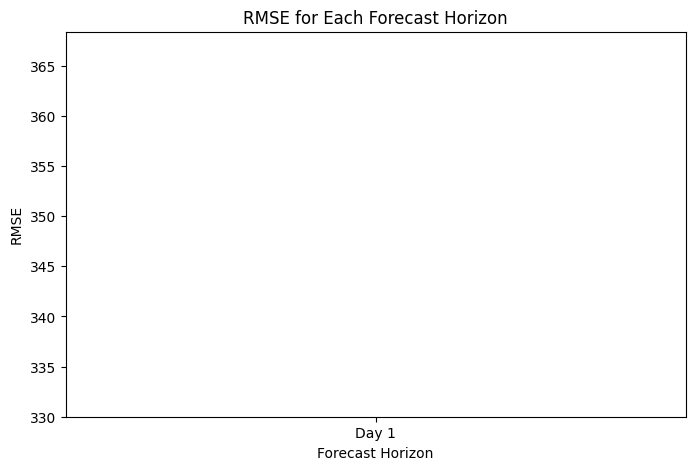

In [206]:
def plot_rmse_for_each_horizon(rmse_dict):
    """
    Plots a bar chart of RMSE for each forecast horizon.
    
    Parameters:
      rmse_dict : Dictionary with keys like 'Day 1', 'Day 2', ... and RMSE values.
    """
    horizons = list(rmse_dict.keys())
    rmse_values = list(rmse_dict.values())
    
    plt.figure(figsize=(8, 5))
    plt.plot(horizons, rmse_values, color='steelblue')
    plt.xlabel("Forecast Horizon")
    plt.ylabel("RMSE")
    plt.title("RMSE for Each Forecast Horizon")
    plt.show()

# Example usage:
rmse_values = compute_rmse_for_each_horizon(post_processed_df, horizon=HORIZON)
plot_rmse_for_each_horizon(rmse_values)

ValueError: x and y must have same first dimension, but have shapes (1,) and (5,)

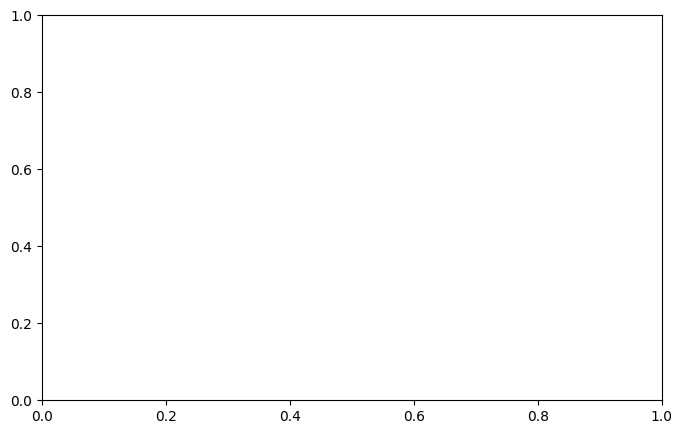

In [208]:
# Hard-coded RMSE values from R
rmse_yhat1 = [647.6976, 922.0222, 1126.1235, 1266.7477, 1356.4172]
rmse_yhatp = [559.0008, 893.0612, 1106.6746, 1248.3544, 1339.4242]

horizons = list(range(1,HORIZON+1))

# Plot each list with a line
plt.figure(figsize=(8, 5))
plt.plot(horizons, rmse_yhat1, marker='o', label='Yhat1')
plt.plot(horizons, rmse_yhatp, marker='o', label='YhatP')
plt.plot(horizons, rmse_values.values(), marker='o', label='LSTM')

plt.xlabel("Horizon k")
plt.ylabel("RMSE")
plt.title("RMSE for Each Forecast Horizon")
plt.legend()
plt.show()

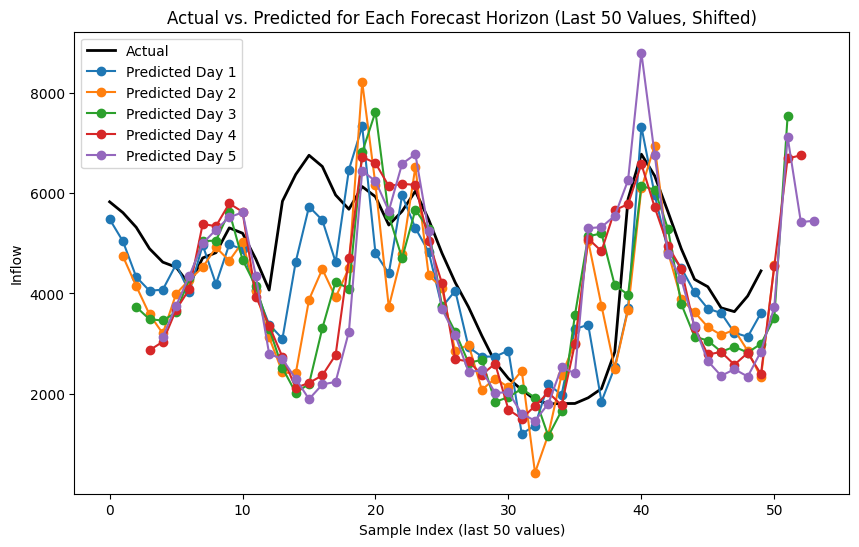

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_multi_horizon_single_actual_shifted(df, horizon=HORIZON, last_n=50):
    """
    Plots one actual line (since all horizons share the same actual values)
    and the predicted values for each forecast horizon on a single figure,
    using only the last 'last_n' samples, but SHIFTING each horizon's line
    so it aligns with the actual day it predicts.

    Assumes the DataFrame has:
      - An actual column named "Day 1 Actual"
      - Predicted columns for each horizon: "Day 1 Pred", "Day 2 Pred", ..., "Day k Pred"

    Parameters:
      df      : DataFrame with at least these columns
      horizon : Number of forecast days (e.g., 5)
      last_n  : How many of the final samples to plot
    """
    plt.figure(figsize=(10, 6))

    # We'll create an x-array for the "last_n" points
    # Day 1 predictions align at x, Day 2 at x+1, Day 3 at x+2, etc.
    x = np.arange(last_n)

    # Plot only the last 'last_n' samples of the actual values
    actual = df["Day 1 Actual"].tail(last_n).values
    plt.plot(x, actual, label="Actual", color="black", linewidth=2)

    # Plot each horizon with a horizontal shift of (i - 1)
    for i in range(1, horizon + 1):
        pred_col = f"Day {i} Pred"
        preds = df[pred_col].tail(last_n).values

        # Shift Day i's predictions by (i-1) steps
        x_shifted = x + (i - 1)
        plt.plot(x_shifted, preds, marker='o', label=f"Predicted Day {i}")

    plt.xlabel(f"Sample Index (last {last_n} values)")
    plt.ylabel("Inflow")
    plt.title(f"Actual vs. Predicted for Each Forecast Horizon (Last {last_n} Values, Shifted)")
    plt.legend()
    plt.show()

# Example usage:
plot_multi_horizon_single_actual_shifted(post_processed_df, horizon=HORIZON, last_n=50)

